# Subspace graph

Try connecting up these subspaces between layers.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1922977544
set_all_seeds(seed)
print(seed)

3903646048


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


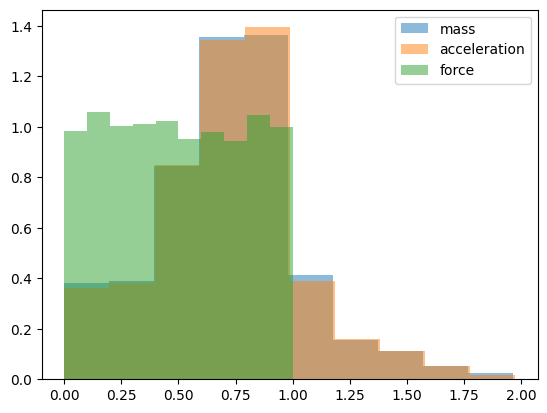

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

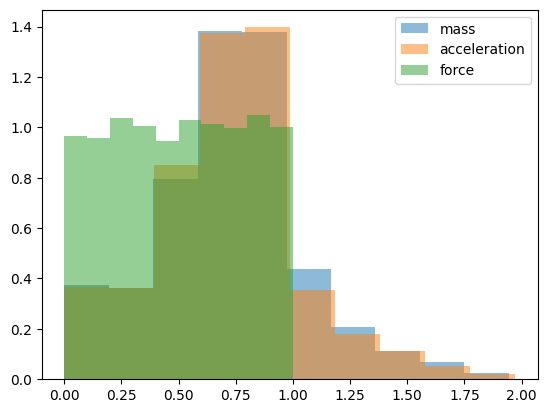

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

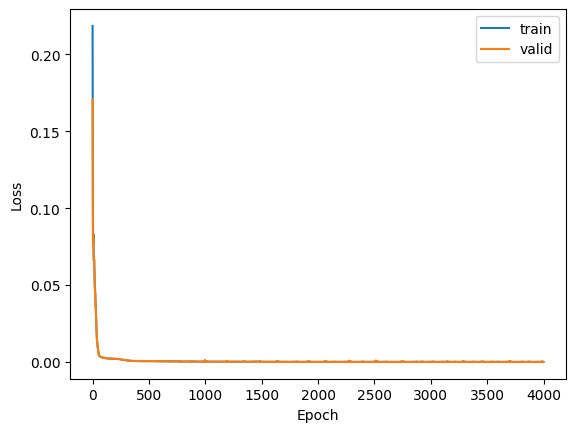

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0001)

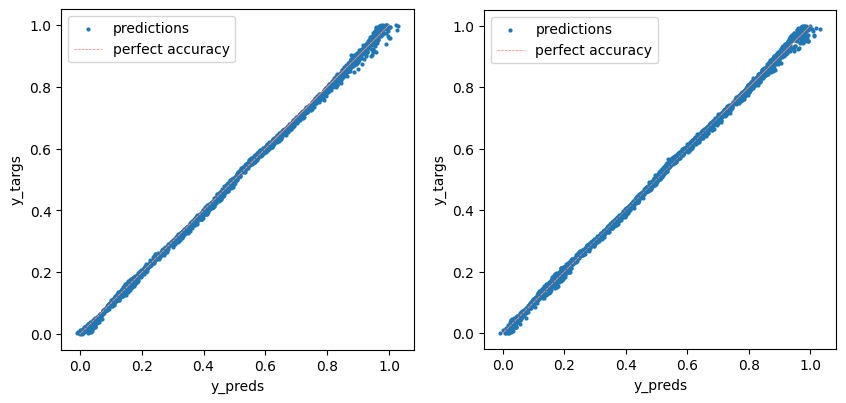

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
inputs = torch.cat((get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B")))
inputs.shape

torch.Size([20000, 4])

In [17]:
ios = capture_intermediate_outputs(model, inputs)

Now we'd like to compare the principal components at `layers.0.act` with those from `layers.1.act` I think.

In [18]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [19]:
acts0 = ios["layers.0.act"]
acts1 = ios["layers.1.act"]
acts0.shape, acts1.shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [20]:
pcs0, vars0 = get_pcs(acts0)
pcs1, vars1 = get_pcs(acts1)
pcs0.shape, pcs1.shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [21]:
pc_acts0 = torch.matmul(pcs0, acts0.T).T
pc_acts1 = torch.matmul(pcs1, acts1.T).T
pc_acts0.shape, pc_acts1.shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [22]:
combined = torch.cat((pc_acts0, pc_acts1), dim=1)

# Compute the covariance matrix of the combined tensor, which will be [32, 32]
cov_matrix_full = torch.cov(combined.T)

# Extract the [16, 16] covariance matrix between X and Y
# This is the top-right or bottom-left quadrant of the full covariance matrix
cov_matrix_XY = cov_matrix_full[0:16, 16:32]

cross_cov_matrix = cov_matrix_XY.numpy()

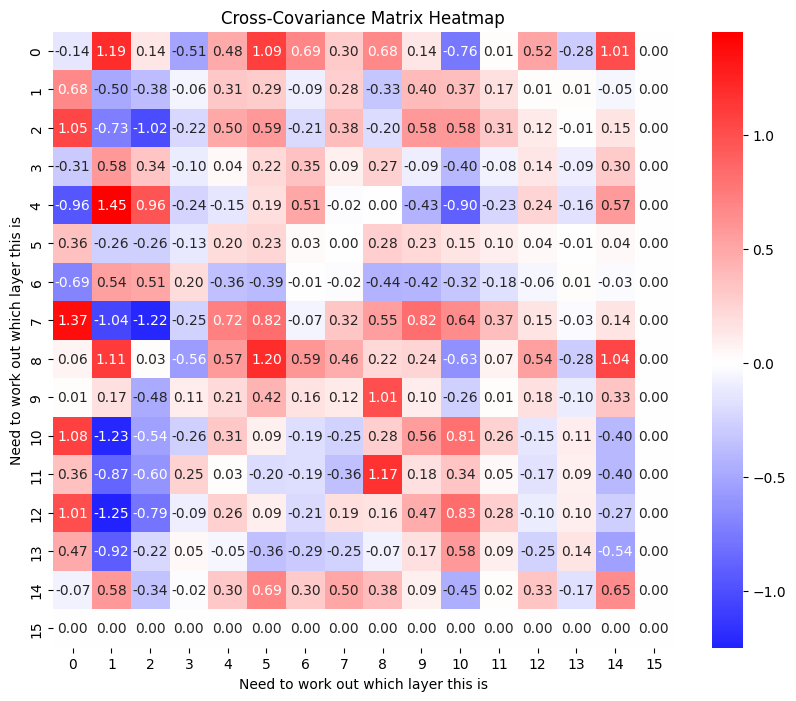

In [23]:
import seaborn as sns

# Plotting the heatmap
_, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cross_cov_matrix * 100, annot=True, fmt=".2f", cmap="bwr", center=0, ax=ax)
ax.set_xlabel("Need to work out which layer this is")
ax.set_ylabel("Need to work out which layer this is")
_ = ax.set_title("Cross-Covariance Matrix Heatmap")

So here I guess we're most interested in the upper left quadrant in terms of defining our graph. Let's check that:

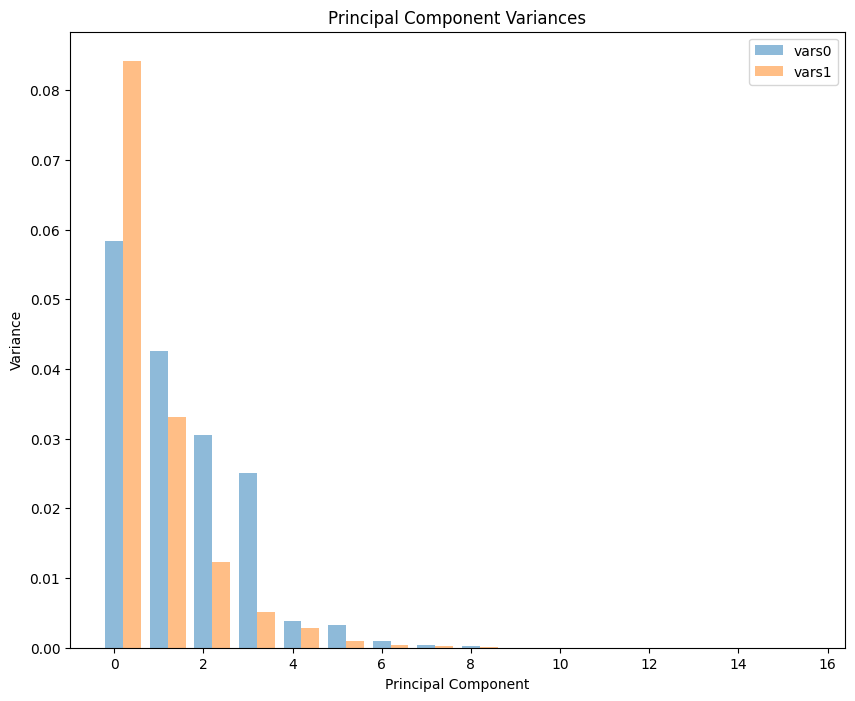

In [24]:
# a bar chart of the principal component variances for vars0 and vars1
_, ax = plt.subplots(figsize=(10, 8))
ax.bar(range(len(vars0)), vars0, label="vars0", width=0.4, alpha=0.5)
ax.bar([i + 0.4 for i in range(len(vars1))], vars1, label="vars1", width=0.4, alpha=0.5)
ax.legend()
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance")
_ = ax.set_title("Principal Component Variances")

Yep, as expected. But to be honest, let's keep things dense for now and we can always prune the graph later if we'd like to.

Now I reckon we need to think about how where going to extract our different subgraphs i.e. do graph clustering. This is interesting to me because I don't work with graph data that much 🤤

Things to consider:
- some of my graph "weights" are negative for negative correlations. I suppose I'm most interested in the absolute values in terms of connectivity, but I'd like to retain the sign because that's useful info.

Trying spectral clustering because that's what GPT thinks is a good place to start:

In [25]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming 'incidence_matrix' is your bipartite graph incidence matrix
# where rows represent nodes of one type and columns represent nodes of the other type.
incidence_matrix = cross_cov_matrix

# Extract edge weights from the incidence matrix.
edge_weights = incidence_matrix[incidence_matrix.nonzero()].reshape(-1, 1)

# Perform clustering on the edge weights
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(edge_weights)

# Get the cluster labels for each edge weight
edge_clusters = kmeans.labels_

# Initialize a matrix to hold the cluster labels for each edge
cluster_label_matrix = np.zeros((16, 16), dtype=int)

# Assign cluster labels to the corresponding edges in the matrix
rows, cols = incidence_matrix.nonzero()
for row, col, cluster in zip(rows, cols, edge_clusters):
    cluster_label_matrix[
        row, col
    ] = cluster  # Adding 1 so that cluster index starts from 1

/Users/JBremner/miniconda3/envs/physics-mi/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


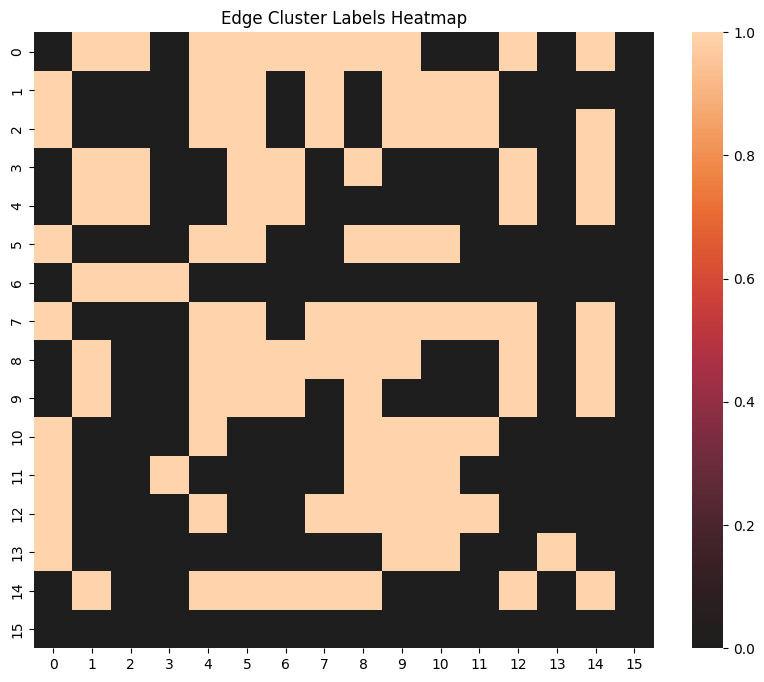

In [26]:
import seaborn as sns

# Plotting the heatmap
_, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cluster_label_matrix, center=0, ax=ax)
_ = ax.set_title("Edge Cluster Labels Heatmap")

Not sure if this makes sense or not. Probably good to revisit when I'm fresh.

TBC.

It's more actually that I'd like a $(16,16,2)$ matrix which soft-weights the edge to each component and task combo. That way I could "light up" the graph with the weights for each task and I'd hope there'd be some separation.

NOTE: see next experiment. I'm going to revisit this one in `003` but with the PCs captured from the validation set.